## Reto 1: Pruebas A/B

### 1. Objetivos:
    - Practicar evaluar los resultados de una Prueba A/B
 
---
    
### 2. Desarrollo:

### a) Evaluando una prueba A/B de flujo de ventas

El archivo 'ab_test-sales_pipeline-2' tiene datos muy similares a los que vimos en el último ejemplo. Estamos evaluando dos flujos de ventas distintos: A y B. Cada vez que alguien compró el producto gracias a uno de los dos flujos, se registró como un `1` en la columna `conversion` y un `0` en la columna `no conversion`.

Evalúa la prueba A/B para saber si los resultados obtenidos son estadísticamente significativos. El Reto consiste en los siguientes pasos:

1. Primero cuantifica cuál de los flujos de ventas fue más efectivo y en qué proporción.
2. Después aplica el test de permutación:
    1. Combina los resultados de ambos grupos en un mismo conjunto de datos
    2. Revuelve los datos
    3. Usando muestreo aleatorio sin reposición, construye un nuevo grupo A del mismo tamaño que el original.
    4. El resto de los datos conforman nuestro nuevo grupo B.
    5. Cuantifica la métrica o estadística que calculaste con los grupos originales y guarda el resultado.
    6. Repite los pasos 1-5 `R` veces para obtener una distribución de la estadística de interés.
3. Grafica tus resultados en un histograma y grafica una línea vertical que marque el resultado del experimento.
4. Cuantifica el Valor P y evalúa la significación estadística con un Alfa de 0.05 (5%).
5. Comenta tus hallazgos con tus compañeros y la experta.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/jaeem006/beduadp/master/Datasets/ab_test-sales_pipeline-2.csv")
df.sample(3)

,test,conversion,no conversion
4644,B,0,1
37776,B,1,0
36186,B,0,1


## Comprobar (sin prueba de permutación) los test de conversion


In [3]:
total_test_conv = df.groupby('test')[['conversion', 'no conversion']].sum()
total_test_conv['success_rate'] = total_test_conv['conversion']\
                                  / (total_test_conv['conversion'] + total_test_conv['no conversion'])
total_test_conv

,conversion,no conversion,success_rate
test,,,
A,4163,30576,0.119836
B,4841,36747,0.116404


Ahora vamos a ver las diferencias entre el test A y el B

In [4]:
diferencia_en_proporcion = 1 - (total_test_conv.loc['B']['success_rate'] / total_test_conv.loc['A']['success_rate'])
diferencia_en_porcentaje = diferencia_en_proporcion * 100
print(f'El test A fue {diferencia_en_porcentaje:.2f}% más `efectivo que el test B para generar ventas.')

El test A fue 2.86% más `efectivo que el test B para generar ventas.


## Comprobar (con prueba de permutación) los test de conversion

Para hacer el test de permutación hay que juntar todos los datos en una misma "canasta"

In [5]:
all_measurements = df[['conversion', 'no conversion']]
all_measurements.sample(3)

,conversion,no conversion
68322,0,1
20622,0,1
67499,0,1


In [6]:
# Conocer el numero de pruebas en el dataframe
numero_tests = df['test'].value_counts()
numero_tests

B    41588
A    34739
Name: test, dtype: int64

Ahora vamos a aplicar el resto del algoritmo del test de permutación:

1. Usando muestreo aleatorio sin reposición, construye un nuevo grupo A del mismo tamaño que el original.
2. El resto de los datos conforman nuestro nuevo grupo B.
3. Cuantifica la métrica o estadística que calculaste con los grupos originales y guarda el resultado.
4. Repite los pasos 1-3 **`R`** veces para obtener una distribución de la estadística de interés.

In [7]:
conv_a = []
no_conv_a = []
conv_b = []
no_conv_b = []

for _ in range(1000):
    a = df.sample(numero_tests.loc['A'], replace=False)
    conv_a.append(a['conversion'].sum())
    no_conv_a.append(a['no conversion'].sum())
    
    b = df.loc[~df.index.isin(a.index)]
    conv_b.append(b['conversion'].sum())
    no_conv_b.append(b['no conversion'].sum())

In [8]:
perm_results = pd.DataFrame({
    'conv_a': conv_a,
    'no_conv_a': no_conv_a,
    'conv_b': conv_b,
    'no_conv_b': no_conv_b
})

perm_results.sample(3)

,conv_a,no_conv_a,conv_b,no_conv_b
581,4107,30632,4897,36691
572,4157,30582,4847,36741
553,4126,30613,4878,36710


In [9]:
perm_results['a_conv_rate'] = perm_results['conv_a'] / (perm_results['conv_a'] + perm_results['no_conv_a'])
perm_results['b_conv_rate'] = perm_results['conv_b'] / (perm_results['conv_b'] + perm_results['no_conv_b'])

In [10]:
perm_results

,conv_a,no_conv_a,conv_b,no_conv_b,a_conv_rate,b_conv_rate
0,4057,30682,4947,36641,0.116785,0.118953
1,4130,30609,4874,36714,0.118887,0.117197
2,4058,30681,4946,36642,0.116814,0.118929
3,4138,30601,4866,36722,0.119117,0.117005
4,4172,30567,4832,36756,0.120096,0.116187
...,...,...,...,...,...,...
995,4062,30677,4942,36646,0.116929,0.118832
996,4065,30674,4939,36649,0.117015,0.118760
997,4131,30608,4873,36715,0.118915,0.117173
998,4075,30664,4929,36659,0.117303,0.118520


In [11]:
perm_results['diff'] = 1 - (perm_results['b_conv_rate'] / perm_results['a_conv_rate'])

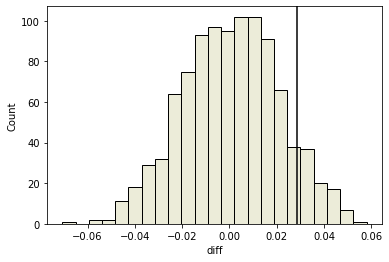

In [12]:
sns.histplot(perm_results['diff'], alpha = 0.15, color = 'olive')
plt.axvline(diferencia_en_proporcion, color = 'black');

Recordando nuestras hipótesis:

* **H0** ➡️ El test A es mayor que el test B
* **H1** ➡️ El test A **no** es mayor que el test B

Y contando con una significancia de 0.05, lo que dice el **valor-p** es:

In [13]:
(perm_results['diff'] >= diferencia_en_proporcion).sum() / perm_results.shape[0]

0.087

No se cuenta con la suficiente información para rechazar la H0